In [13]:
# Untuk manipulasi & analisis data
import pandas as pd
import numpy as np

# Untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk preprocessing data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Untuk membangun model Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

# Untuk mengabaikan pesan peringatan yang tidak krusial
import warnings
warnings.filterwarnings('ignore')

print("DONE")

DONE


In [14]:
# Tentukan path ke file Anda
file_path = 'student-por.csv'

try:
    df = pd.read_csv(file_path, sep=';')
    print(f"Dataset '{file_path}' berhasil dimuat.")
    print(df.head())
except FileNotFoundError:
    print(f"ERROR File '{file_path}' tidak ditemukan.")

Dataset 'student-por.csv' berhasil dimuat.
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]


Nah, di dunia AI ada istilah "Garbage In, Garbage Out", intinya kalo data kita jelek, modelnya juga bakal jelek. Makanya di sel ketiga kita fokus data cleaning. Pertama, kita bikin salinan datanya pake .copy() biar data aslinya aman. Dataset ini kebetulan udah bersih dari data kosong atau duplikat, tapi kita tetep fokus ke outlier di kolom absences. Ada data siswa yang absennya banyak banget, ini bisa ngerusak model. Jadi, kita pake metode IQR buat nentuin batas wajar jumlah absen, terus nilai-nilai yang kelewat batas kita "teken" pake .clip(). Ini lebih bagus daripada ngehapus data.

In [15]:
# Membuat salinan DataFrame agar data asli tidak berubah
df_processed = df.copy()

print("### Memulai Proses Data Cleaning ###")

# Cek Missing & Duplicate Values
print(f"- Ditemukan {df_processed.isnull().sum().sum()} missing value.")
print(f"- Ditemukan {df_processed.duplicated().sum()} baris duplikat.")

# Mengatasi Outlier pada kolom 'absences'
Q1 = df_processed['absences'].quantile(0.25)
Q3 = df_processed['absences'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
outliers_count = len(df_processed[df_processed['absences'] > upper_bound])
print(f"- Ditemukan {outliers_count} outlier pada kolom 'absences'.")

# Mengganti outlier dengan nilai batas atas (Capping)
df_processed['absences'] = df_processed['absences'].clip(upper=upper_bound)
print("Outlier telah diatasi dengan metode Capping.")

### Memulai Proses Data Cleaning ###
- Ditemukan 0 missing value.
- Ditemukan 0 baris duplikat.
- Ditemukan 21 outlier pada kolom 'absences'.
Outlier telah diatasi dengan metode Capping.


Di sel keempat, kita masuk ke bagian yang sedikit kreatif, yaitu feature engineering. Di sini kita bikin fitur baru total_alcohol dengan cara nggabungin Dalc (alkohol pas hari kerja) dan Walc (alkohol pas weekend). Idenya simpel, informasi gabungan ini mungkin lebih "ngena" buat model daripada kalo fiturnya dipisah-pisah.

In [16]:
print("### Memulai Feature Engineering ###")

# Membuat fitur baru 'total_alcohol' dari penjumlahan Dalc dan Walc
df_processed['total_alcohol'] = df_processed['Dalc'] + df_processed['Walc']

print("Fitur baru 'total_alcohol' berhasil dibuat.")

### Memulai Feature Engineering ###
Fitur baru 'total_alcohol' berhasil dibuat.


Lanjut di sel kelima, kita ngelakuin standarisasi. Neural network itu sensitif banget sama skala angka. Bayangin aja, fitur age (15-22) sama absences (0-15) kan skalanya beda. Kalo dibiarin, model bisa ngira fitur yang angkanya lebih gede itu lebih penting. Nah, StandardScaler ini tugasnya nyamain "level" semua fitur numerik, jadi rata-ratanya 0 dan standar deviasinya 1.

In [17]:
print("### Memulai Standarisasi Kolom Numerik ###")

# Pilih semua kolom numerik (termasuk fitur baru)
numeric_cols = df_processed.select_dtypes(include=np.number).columns
scaler = StandardScaler()

# Terapkan standarisasi
df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])

print("Semua kolom numerik telah distandarisasi.")

### Memulai Standarisasi Kolom Numerik ###
Semua kolom numerik telah distandarisasi.


Terus di sel keenam, kita ngurusin data teks. Model mana ngerti sama huruf kaya 'M' atau 'F'? Makanya kita pake One-Hot Encoding lewat pd.get_dummies(). Intinya, kita ubah data-data teks itu jadi kolom-kolom baru yang isinya cuma angka 0 dan 1, biar model bisa ngerti.

In [18]:
print("### Memulai Encoding Kolom Kategorikal ###")

# Pilih semua kolom non-numerik (object)
categorical_cols = df_processed.select_dtypes(include=['object']).columns

# Lakukan One-Hot Encoding
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print(f"Kolom kategorikal telah di-encode. Jumlah total kolom sekarang: {df_processed.shape[1]}")

### Memulai Encoding Kolom Kategorikal ###
Kolom kategorikal telah di-encode. Jumlah total kolom sekarang: 43


Setelah semua data siap tempur, di sel ketujuh kita lakuin langkah paling krusial: splitting data. Data kita bagi jadi dua: data training (80%) buat "ngelatih" model, dan data testing (20%) yang kita simpen rapi buat "ujian akhir" modelnya. Ini penting banget biar kita bisa nilai performa model secara objektif.

In [19]:
print("### Memulai Pembagian Data ###")

# Tentukan X (fitur) dan y (target)
X = df_processed.drop('G3', axis=1)
y = df_processed['G3']

# Bagi data: 80% untuk training, 20% untuk testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data telah dibagi menjadi data training dan testing.")
print(f"   -> Ukuran data training (X_train): {X_train.shape}")
print(f"   -> Ukuran data testing (X_test)  : {X_test.shape}")

### Memulai Pembagian Data ###
Data telah dibagi menjadi data training dan testing.
   -> Ukuran data training (X_train): (519, 42)
   -> Ukuran data testing (X_test)  : (130, 42)


Di sel kedelapan, kita mulai masuk ke bagian serunya dari Modul 6: ngerancang arsitektur DNN. Kita pake model Sequential dari Keras, jadi kita bisa nambahin layer satu per satu kaya nyusun lego. Arsitekturnya simpel: 1 input layer, 3 hidden layer pake aktivasi relu (ini keren buat nangkep pola-pola rumit), dan 1 output layer. Karena kita mau nebak angka (regresi), output layer-nya cuma butuh 1 neuron aja.

In [20]:
print("### Membangun Arsitektur Model DNN ###")

# Membuat model Sequential
model = Sequential()

# Menambahkan layer-layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu')) # Input & Hidden Layer 1
model.add(Dense(64, activation='relu'))                             # Hidden Layer 2
model.add(Dense(32, activation='relu'))                             # Hidden Layer 3
model.add(Dense(1))                                                 # Output Layer (untuk regresi)

# Menampilkan ringkasan arsitektur
model.summary()

### Membangun Arsitektur Model DNN ###


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,873 (62.00 KB)

 Trainable params: 15,873 (62.00 KB)

 Non-trainable params: 0 (0.00 B)

Setelah arsitekturnya jadi, di sel kesembilan kita compile modelnya. Ini kaya ngasih "aturan main" buat modelnya belajar. optimizer='adam' itu cara belajarnya yang udah terbukti efektif, sementara loss='mean_absolute_error' itu cara kita ngukur seberapa parah kesalahan tebakan model. Tujuan kita selama training nanti adalah bikin nilai loss ini sekecil mungkin.

In [23]:
print("### Melakukan Compile Model ###")

model.compile(optimizer='adam', 
              loss='mean_absolute_error', 
              metrics=['mean_squared_error'])

print("Model berhasil di-compile dan siap untuk dilatih.")

### Melakukan Compile Model ###
Model berhasil di-compile dan siap untuk dilatih.


Di sel kesepuluh, proses belajar atau training beneran dimulai pake model.fit(). Model bakal "melihat" data training berulang-ulang sebanyak 50 epoch. Di setiap epoch, model bakal terus-terusan nyesuain "pemahamannya" biar tebakannya makin akurat.

In [25]:
print("### Memulai Proses Training Model... ###")

# Melatih model selama 50 epoch
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32,
                    validation_split=0.2, # Gunakan sebagian data train untuk validasi
                    verbose=1) # Tampilkan progress bar

print("\nProses training selesai.")

### Memulai Proses Training Model... ###
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0382 - mean_squared_error: 0.0027 - val_loss: 0.2607 - val_mean_squared_error: 0.1179
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0432 - mean_squared_error: 0.0036 - val_loss: 0.2592 - val_mean_squared_error: 0.1174
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0461 - mean_squared_error: 0.0039 - val_loss: 0.2586 - val_mean_squared_error: 0.1141
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0403 - mean_squared_error: 0.0029 - val_loss: 0.2603 - val_mean_squared_error: 0.1199
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0380 - mean_squared_error: 0.0031 - val_loss: 0.2603 - val_mean_squared_error: 0.1173
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0321 - mean_squared_error: 0.0019 - val_loss: 0.2574 - val_mean_squared_error: 0.1148
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0346 - mean_squared_err

Setelah model "lulus" dari training, di sel kesebelas kita kasih dia "ujian akhir" pake model.evaluate() di data testing. Dari sini kita dapet nilai MAE (Mean Absolute Error), yang intinya ngasih tau kita rata-rata seberapa jauh tebakan model meleset dari nilai aslinya.

In [11]:
print("### Mengevaluasi Performa Model ###")

# Evaluasi model pada data test
loss, mse = model.evaluate(X_test, y_test, verbose=0)

print(f"-> Mean Absolute Error (MAE): {loss:.4f}")
print(f"-> Mean Squared Error (MSE) : {mse:.4f}")
print("\nMAE menunjukkan rata-rata seberapa jauh prediksi model dari nilai sebenarnya.")

### Mengevaluasi Performa Model ###
-> Mean Absolute Error (MAE): 0.3009
-> Mean Squared Error (MSE) : 0.2023

MAE menunjukkan rata-rata seberapa jauh prediksi model dari nilai sebenarnya.


Terakhir, di sel dua belas, kita visualisasiin hasilnya. Angka MAE emang penting, tapi gambar seringkali lebih "bicara". Kita bikin scatter plot buat ngebandingin nilai asli vs nilai prediksi. Ada garis merah diagonal yang nunjukkin "prediksi sempurna". Makin deket titik-titik data kita ke garis merah itu, berarti model kita pinter dan akurat

### Visualisasi Hasil Prediksi ###
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


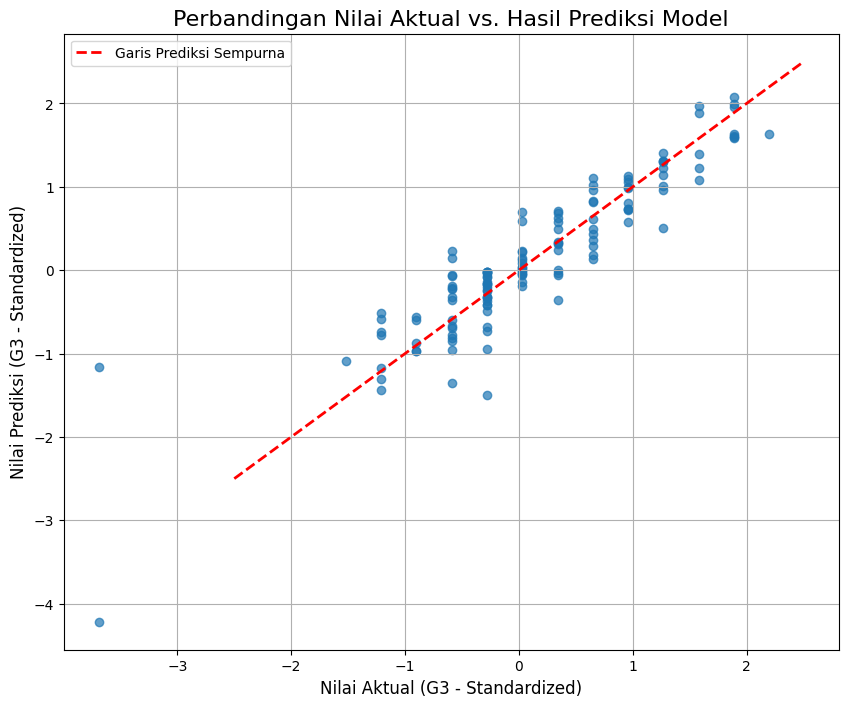

In [26]:
print("### Visualisasi Hasil Prediksi ###")

# Buat prediksi pada data test
predictions = model.predict(X_test).flatten()

# Buat scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, predictions, alpha=0.7)
plt.plot([-2.5, 2.5], [-2.5, 2.5], '--', color='red', linewidth=2, label='Garis Prediksi Sempurna')
plt.title('Perbandingan Nilai Aktual vs. Hasil Prediksi Model', fontsize=16)
plt.xlabel('Nilai Aktual (G3 - Standardized)', fontsize=12)
plt.ylabel('Nilai Prediksi (G3 - Standardized)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()